In [24]:
from indra_cogex.client import Neo4jClient
import indra_cogex.info
from indra_cogex.client.curation import PHOSPHATASE_CURIES
from rich import print
from collections import Counter, defaultdict
import pandas as pd
from indra.databases import hgnc_client
from indra_cogex.apps.curator.curation_cache import CurationCache
from indra_cogex.client.queries import enrich_statements
import builtins
import random
import seaborn as sns
from indra.util.statement_presentation import db_sources
from more_itertools import chunked
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import json
from indra.statements import stmts_from_json, Statement
import pyobo
import matplotlib.pyplot as plt
from IPython.display import HTML, Markdown
from matplotlib_venn import venn2, venn3
from pyobo.struct import TypeDef

set_matplotlib_formats("svg")
PHOSPHATASE_CURIES = set(PHOSPHATASE_CURIES)
INDRA_PHOSPHATASE_IDS = {x.removeprefix("hgnc:") for x in PHOSPHATASE_CURIES}

indra_cogex.info.env()

Key,Value
OS,posix
Platform,Darwin
Release,21.5.0
Time,Thu Jun 2 15:09:28 2022
Python,3.9.12
INDRA Version,1.21.0
INDRA Git Hash,b3a05272a1e712733992f6b8040728ec383ca4e1
INDRA CoGEx Version,1.0.0
INDRA CoGEx Git Hash,39f222c7f1a6347d7d70143a7e9a853debda0a3d
INDRA CoGEx Branch,update-curation-cache


In [2]:
curation_cache = CurationCache()

INFO: [2022-06-02 15:04:12] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list
INFO: [2022-06-02 15:04:12] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2022-06-02 15:04:12] indra.sources.indra_db_rest.util - data: None


In [3]:
def get_correct_statement_hashes() -> set[int]:
    stmt_hash_to_tags = defaultdict(set)
    for curation in curation_cache.get_curation_cache(only_most_recent=True):
        stmt_hash_to_tags[curation["pa_hash"]].add(curation["tag"])
    return {
        stmt_hash
        for stmt_hash, tags in stmt_hash_to_tags.items()
        if any(tag == "correct" for tag in tags)
    }


def get_heuristic_incorrect_statement_hashes(threshold: int = 5) -> set[int]:
    stmt_hash_to_tags = defaultdict(set)
    for curation in curation_cache.get_curation_cache(only_most_recent=True):
        stmt_hash_to_tags[curation["pa_hash"]].add(curation["tag"])
    return {
        stmt_hash
        for stmt_hash, tags in stmt_hash_to_tags.items()
        if threshold < sum(tag != "correct" for tag in tags)
    }

In [4]:
client = Neo4jClient()

INFO: [2022-06-02 15:04:19] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2022-06-02 15:04:19] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection


In [5]:
%%time
query = f"""\
MATCH (a:BioEntity)-[r:indra_rel]->(b:BioEntity)
WHERE
    a.id STARTS WITH "hgnc"
    AND b.id STARTS WITH "hgnc"
    AND a.id <> b.id
    AND r.stmt_type = "Dephosphorylation"
RETURN a.id, a.name, collect(r.stmt_json)
"""

incorrect_statement_hashes = get_heuristic_incorrect_statement_hashes()
dephosphorylations: list[tuple[str, str, list[Statement]]] = [
    (curie, name, stmts_from_json(json.loads(stmt_json) for stmt_json in stmt_jsons))
    for curie, name, stmt_jsons in client.query_tx(query)
]

CPU times: user 2.16 s, sys: 237 ms, total: 2.4 s
Wall time: 23.3 s


In [6]:
for stmts in chunked(
    tqdm(
        [stmt for _, _, stmts in dephosphorylations for stmt in stmts],
        desc="Enriching statements with evidences",
        unit_scale=True,
        unit="statement",
    ),
    n=5000,
):
    enrich_statements(stmts, client=client)

Enriching statements with evidences:   0%|          | 0.00/20.8k [00:00<?, ?statement/s]

INFO: [2022-06-02 15:04:43] indra_cogex.client.queries - looking up evidence for 5000 statements
INFO: [2022-06-02 15:04:51] indra_cogex.client.queries - got 11442 evidences in 7.98 seconds
INFO: [2022-06-02 15:04:51] indra_cogex.client.queries - looking up evidence for 5000 statements
INFO: [2022-06-02 15:04:56] indra_cogex.client.queries - got 9901 evidences in 5.89 seconds


INFO: [2022-06-02 15:04:57] indra_cogex.client.queries - looking up evidence for 5000 statements
INFO: [2022-06-02 15:05:00] indra_cogex.client.queries - got 8457 evidences in 3.17 seconds
INFO: [2022-06-02 15:05:00] indra_cogex.client.queries - looking up evidence for 5000 statements
INFO: [2022-06-02 15:05:02] indra_cogex.client.queries - got 6739 evidences in 2.74 seconds
INFO: [2022-06-02 15:05:02] indra_cogex.client.queries - looking up evidence for 831 statements
INFO: [2022-06-02 15:05:03] indra_cogex.client.queries - got 1107 evidences in 0.60 seconds


In [7]:
incorrect_evidence_hashes = curation_cache.get_incorrect_evidence_hashes(
    only_most_recent=True
)


def remove_wrong_evidences(stmt: Statement):
    stmt.evidence = [
        evidence
        for evidence in stmt.evidence
        if evidence.get_source_hash() not in incorrect_evidence_hashes
    ]
    return stmt


def keep(stmt: Statement) -> bool:
    if not stmt.evidence:
        return False
    if all(evidence.source_api == "sparser" for evidence in stmt.evidence):
        return False
    if any(evidence.epistemics.get("direct") == False for evidence in stmt.evidence):
        return False
    return True


filtered_dephosphorylations = [
    (
        curie,
        name,
        [new_stmt for stmt in stmts if keep(new_stmt := remove_wrong_evidences(stmt))],
    )
    for curie, name, stmts in dephosphorylations
]

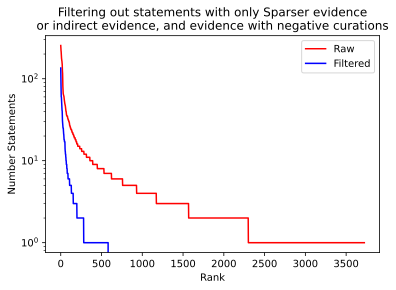

In [8]:
raw_distribution = sorted([len(s) for _, _, s in dephosphorylations], reverse=True)
filt_distribution = sorted(
    [len(s) for _, _, s in filtered_dephosphorylations], reverse=True
)
x = list(range(len(dephosphorylations)))

ax = sns.lineplot(x=x, y=raw_distribution, color="red", label="Raw")
sns.lineplot(x=x, y=filt_distribution, ax=ax, color="blue", label="Filtered")
ax.set_yscale("log")
ax.set_ylabel("Number Statements")
ax.set_xlabel("Rank")
ax.set_title(
    "Filtering out statements with only Sparser evidence\n"
    "or indirect evidence, and evidence with negative curations"
)
plt.legend()
plt.show()

In [9]:
novel_dict, known_dict = defaultdict(list), defaultdict(list)
for row in filtered_dephosphorylations:
    if not row[2]:  # skip rows with no statements
        continue
    if row[0] not in PHOSPHATASE_CURIES:
        novel_dict[row[0]].append(row)
    else:
        known_dict[row[0]].append(row)

novel_dict = dict(novel_dict)
known_dict = dict(known_dict)

print(f"There are {len(novel_dict):,} genes with novel phosphatase activities")
print(
    f"There are {len(known_dict):,}/{len(PHOSPHATASE_CURIES)}"
    f" ({len(known_dict)/len(PHOSPHATASE_CURIES):.1%}) phosphatase genes w/ dephosphorylation statements"
)

dark_phosphatase_curies = PHOSPHATASE_CURIES.difference(known_dict)
print(
    f"There are {len(dark_phosphatase_curies):,}/{len(PHOSPHATASE_CURIES)}"
    f" ({len(dark_phosphatase_curies)/len(PHOSPHATASE_CURIES):.1%}) phosphatase genes"
    " w/o dephosphorylation statements"
)

There are 470 genes with novel phosphatase activities

There are 112/184 (60.9%) phosphatase genes w/ dephosphorylation statements

There are 72/184 (39.1%) phosphatase genes w/o dephosphorylation statements

In [10]:
hgnc_groups = pyobo.get_ontology("hgnc.genefamily")
hgnc_ontology = pyobo.get_ontology("hgnc")

INFO: [2022-06-02 15:05:05] pyobo.getters - [hgnc.genefamily] caching nomenclature plugin
INFO: [2022-06-02 15:05:05] pyobo.struct.struct - [hgnc.genegroup vNone] caching metadata to /Users/cthoyt/.data/pyobo/raw/hgnc.genegroup/metadata.json
INFO: [2022-06-02 15:05:05] pyobo.struct.struct - [hgnc.genegroup vNone] caching metadata to /Users/cthoyt/.data/pyobo/raw/hgnc.genegroup/cache/metadata.json
INFO: [2022-06-02 15:05:05] pyobo.struct.struct - [hgnc.genegroup vNone] caching typedefs to /Users/cthoyt/.data/pyobo/raw/hgnc.genegroup/cache/typedefs.tsv
INFO: [2022-06-02 15:05:05] pyobo.getters - [hgnc] caching nomenclature plugin
INFO: [2022-06-02 15:05:05] pyobo.struct.struct - [hgnc vNone] caching metadata to /Users/cthoyt/.data/pyobo/raw/hgnc/metadata.json
INFO: [2022-06-02 15:05:05] pyobo.struct.struct - [hgnc vNone] caching metadata to /Users/cthoyt/.data/pyobo/raw/hgnc/cache/metadata.json
INFO: [2022-06-02 15:05:05] pyobo.struct.struct - [hgnc vNone] caching typedefs to /Users/ctho

In [11]:
# hgnc.group:703 is protein phosphatases
# hgnc.group:1076 is all phosphatases
hgnc_phosphatase_families = set(hgnc_groups.descendants("1076"))


subfamilies = [
    "1066",  # lipid phosphatases
    "1073",  # sugar phosphatases
    "1042",  # nucleotidases
]
for subfamily in subfamilies:
    subfamily_genes = hgnc_groups.descendants(subfamily)
    hgnc_phosphatase_families -= subfamily_genes
    hgnc_phosphatase_families -= {subfamily}


# hgnc_phosphatase_families = hgnc_groups.descendants("703")

hgnc_phosphatases: set[str] = {
    term.identifier
    for term in hgnc_ontology
    if any(
        reference.identifier in hgnc_phosphatase_families
        for typedef, references in term.relationships.items()
        if typedef.prefix == "RO" and typedef.identifier == "0002350"
        for reference in references
    )
}

Mapping hgnc.genegroup: 100%|███████████████████████████████████████████████████████████████| 1638/1638 [00:00<00:00, 75643.77it/s]
Mapping hgnc:   0%|                                                                                 | 0.00/43.0k [00:00<?, ?gene/s]WARNING: [2022-06-02 15:05:11] pyobo.utils.misc - [uniprot] bizarre version: 2022_02
INFO: [2022-06-02 15:05:11] pyobo.api.names - [uniprot v2022_02] no cached names found. getting from OBO loader
INFO: [2022-06-02 15:05:11] pyobo.getters - [uniprot] caching nomenclature plugin
INFO: [2022-06-02 15:05:11] pyobo.struct.struct - [uniprot v2022_02] caching metadata to /Users/cthoyt/.data/pyobo/raw/uniprot/metadata.json
INFO: [2022-06-02 15:05:11] pyobo.struct.struct - [uniprot v2022_02] caching metadata to /Users/cthoyt/.data/pyobo/raw/uniprot/2022_02/cache/metadata.json
INFO: [2022-06-02 15:05:11] pyobo.struct.struct - [uniprot v2022_02] caching typedefs to /Users/cthoyt/.data/pyobo/raw/uniprot/2022_02/cache/typedefs.tsv
INFO: [2

------------------------  -----
date_approved_reserved    42977
_version_                 42977
uuid                      42977
location_sortable         42976
date_modified             42973
agr                       40348
date_name_changed         24208
mane_select               18561
prev_symbol               12257
date_symbol_changed        9862
gencc                      4569
symbol_report_tag          3524
iuphar                     3449
lsdb                       2152
horde_id                    856
imgt                        675
gtrnadb                     587
curator_notes               581
bioparadigms_slc            456
cd                          371
homeodb                     312
lncrnadb                    150
intermediate_filament_db     69
mamit-trnadb                 22
------------------------  -----


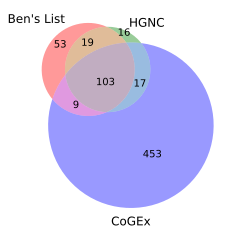

In [12]:
catalytically_inactive_phosphatases = {
    "11447",  # 'STYX', 'https://bioregistry.io/hgnc:11447'
    "18165",  # 'STYXL1'
    "23656",  # 'TIMM50' uniprot says probabily inactive as phosphatase in vivo
}

# proteins with a dephosphorylation statement to another protein
# after filtering
cogex_hgnc_ids = {
    curie.removeprefix("hgnc:")
    for curie, _, stmts in filtered_dephosphorylations
    if stmts
}

venn3(
    [
        INDRA_PHOSPHATASE_IDS,
        hgnc_phosphatases - catalytically_inactive_phosphatases,
        cogex_hgnc_ids,
    ],
    ["Ben's List", "HGNC", "CoGEx"],
)
plt.show()

In [32]:
filtered_hgnc_ids = set()

# I validated the seven that pop out of here are good kinases, too bad they don't appear in INDRA :(
# Maybe they got filtered out and we can find some gems about them
rows = []
for hgnc_id in (
    hgnc_phosphatases
    - INDRA_PHOSPHATASE_IDS
    - filtered_hgnc_ids
    - catalytically_inactive_phosphatases
):
    url = f"https://bioregistry.io/hgnc:{hgnc_id}"
    rows.append((hgnc_id, hgnc_client.get_hgnc_name(hgnc_id), url))

print(tabulate(rows, tablefmt="github"))

|-------|----------|-----------------------------------|
| 33237 | DUSP28   | https://bioregistry.io/hgnc:33237 |
| 16818 | PUDP     | https://bioregistry.io/hgnc:16818 |
| 28763 | PGAM5    | https://bioregistry.io/hgnc:28763 |
| 23424 | PTPN20CP | https://bioregistry.io/hgnc:23424 |
| 20785 | PPM1J    | https://bioregistry.io/hgnc:20785 |
|  3520 | EYA2     | https://bioregistry.io/hgnc:3520  |
| 26845 | PPM1N    | https://bioregistry.io/hgnc:26845 |
| 18583 | PPM1H    | https://bioregistry.io/hgnc:18583 |
| 23423 | PTPN20   | https://bioregistry.io/hgnc:23423 |
| 19737 | TNS2     | https://bioregistry.io/hgnc:19737 |
|  9114 | PMM1     | https://bioregistry.io/hgnc:9114  |
| 29149 | PHLPP2   | https://bioregistry.io/hgnc:29149 |
| 25016 | SSU72    | https://bioregistry.io/hgnc:25016 |
| 26303 | PXYLP1   | https://bioregistry.io/hgnc:26303 |
| 14376 | ACP4     | https://bioregistry.io/hgnc:14376 |
| 16140 | NANP     | https://bioregistry.io/hgnc:16140 |
| 28110 | UBLCP1   | https://bioregistry.io/hgnc:28110 |
| 28781 | MDP1     | https://bioregistry.io/hgnc:28781 |
| 28316 | PHOSPHO2 | https://bioregistry.io/hgnc:28316 |
|  3522 | EYA4     | https://bioregistry.io/hgnc:3522  |
| 24599 | ENOPH1   | https://bioregistry.io/hgnc:24599 |
| 26936 | CTDSPL2  | https://bioregistry.io/hgnc:26936 |
| 29884 | UBASH3B  | https://bioregistry.io/hgnc:29884 |
|  3519 | EYA1     | https://bioregistry.io/hgnc:3519  |
| 33781 | ACP7     | https://bioregistry.io/hgnc:33781 |
| 13421 | PTPRVP   | https://bioregistry.io/hgnc:13421 |
|  9115 | PMM2     | https://bioregistry.io/hgnc:9115  |
|  3402 | EPHX2    | https://bioregistry.io/hgnc:3402  |
|  9279 | PDP1     | https://bioregistry.io/hgnc:9279  |
| 20610 | PHLPP1   | https://bioregistry.io/hgnc:20610 |
| 11973 | TNS1     | https://bioregistry.io/hgnc:11973 |
| 19085 | CTDNEP1  | https://bioregistry.io/hgnc:19085 |
|  3521 | EYA3     | https://bioregistry.io/hgnc:3521  |

# Deeper Dive into Novel Phosphatases

In [46]:
extended_db_sources = set(db_sources) | {"biopax"}
threshold = 2

evidence_hashes = curation_cache.get_curated_evidence_hashes(only_most_recent=True)
correct_evidence_hashes = curation_cache.get_correct_evidence_hashes(
    only_most_recent=True
)
incorrect_evidence_hashes = curation_cache.get_incorrect_evidence_hashes(
    only_most_recent=True
)

# Start by curating statements with small number of evidences
#  that can be fully knocked out in a single curation session
singleton_stmt_hashes = {}
doubleton_stmt_hashes = {}
higher_stmt_hashes = {}
skip_curies = {
    "hgnc:9951",  # PTP often is mis-grounded to REG1A
}
for curie, rows in novel_dict.items():
    if curie in skip_curies:
        continue
    for _, _, stmts in rows:
        for stmt in stmts:
            if any(ev.source_api in extended_db_sources for ev in stmt.evidence):
                continue  # If any evidences are database, don't need to curate

            correct_evidences = sum(
                ev.get_source_hash() in correct_evidence_hashes for ev in stmt.evidence
            )
            incorrect_evidences = sum(
                ev.get_source_hash() in incorrect_evidence_hashes
                for ev in stmt.evidence
            )

            if all(ev.get_source_hash() in evidence_hashes for ev in stmt.evidence):
                if all(ev.get_source_hash() in correct_evidence_hashes for ev in stmt.evidence):
                    print(stmt, f'\nPMID: {stmt.evidence[0].pmid}', f"\n{stmt.evidence[0].text}")

                continue  # Everything is curated

            if 0 < correct_evidences:
                continue  # If an evidences are curated as true, don't need to curate

            # Heuristic - if 10 are curated and none true, then move on
            if 10 < incorrect_evidences:
                continue  # Heuristic to determine false

            if len(stmt.evidence) == 1:
                singleton_stmt_hashes[stmt.get_hash()] = stmt
            elif len(stmt.evidence) == 2:
                doubleton_stmt_hashes[stmt.get_hash()] = stmt
            elif len(stmt.evidence) > threshold:
                higher_stmt_hashes[stmt.get_hash()] = stmt

print(
    f"There are {len(singleton_stmt_hashes):,} statements with singleton evidence, "
    f"{len(doubleton_stmt_hashes)} statements with doubleton evidence, and {len(higher_stmt_hashes)} statements"
    f" with more than {threshold} evidences left to curate."
)

k = 20
sampled_hashes = (
    random.sample(list(higher_stmt_hashes), k=20)
    if len(higher_stmt_hashes) > k
    else list(higher_stmt_hashes)
)
sampled_hash_str = ",".join(map(str, sampled_hashes))
builtins.print(
    f"http://localhost:5000/statement_display?preload=True&stmt_hash={sampled_hash_str}"
)

Dephosphorylation(PHLPP1(), RPS6KB1()) 
PMID: 22340730 
Finally, PHLPP also dephosphorylates the activation loop of S6K1, thus activating PI3K/Akt 
signalling through upregulation of IRS-1 [ xref ].

Dephosphorylation(PDCD1(), LCK()) 
PMID: 19264470 
For example, while CTLA-4 and/or PD-1 could block CD28 mediated AKT activation and could 
recruit Shp-1, Shp-2 (and/or SHIP) to dephosphorylate LCK and other substrates, some partial 
TCR signaling could still occur.

Dephosphorylation(PPT1(), CDC37()) 
PMID: 18922470 
Furthermore, we have shown that PP5 and Ppt1 and Cdc37 simultaneously associate with Hsp90 
complexes invitro and invivo, and that PP5 and Ppt1 dephosphorylates Cdc37 in such complexes.

Dephosphorylation(PPM1H(), CDKN1B(), T, 187) 
PMID: 22586611 
PPM1H dephosphorylates p27 at threonine 187, thus removing a signal for proteasomal 
degradation.

Dephosphorylation(SGK1(), VCL()) 
PMID: 22309306 
More importantly, mAR activation restored vinculin phosphorylation in SGK1-SD-transfected 
cells, whereas silencing of vinculin fully reversed the mAR-induced inhibition of the 
migratory capacity, implying that this protein is directly involved in cell motility 
regulation by SGK1 and mAR. This study indicates for the first time that SGK1 regulates cell 
migration via vinculin dephosphorylation, a mechanism that is controlled by mAR function.

Dephosphorylation(ABI2(), BIN2()) 
PMID: 29275167 
Abscisic Acid Signaling Inhibits Brassinosteroid Signaling through Dampening the 
Dephosphorylation of BIN2 by ABI1 and ABI2.

Dephosphorylation(ABI1(), BIN2()) 
PMID: 29275167 
Abscisic Acid Signaling Inhibits Brassinosteroid Signaling through Dampening the 
Dephosphorylation of BIN2 by ABI1 and ABI2.

Dephosphorylation(EYA3(), WDR1()) 
PMID: 29440662 
WDR1 is phosphorylated by Src kinase and dephosphorylated by EYA3 phosphatase.

Dephosphorylation(PPA1(), MAPK8()) 
PMID: 33583053 
Besides pyrophosphate hydrolysis, PPA1 can also directly dephosphorylate phosphorylated JNK1.

Dephosphorylation(PGAM5(), FUNDC1(), 13) 
PMID: None 
PGAM5 (PGAM family member 5) dephosphorylates FUNDC1 at serine 13 to enhance FUNDC1 
interaction with LC3, whereas CK2 (creatine kinase 2) phosphorylates FUNDC1 to reverse the 
effect of PGAM5.

Dephosphorylation(EYA4(), CTNNB1(), S, 675) 
PMID: 29764501 
Because our previous studies demonstrated that EYA4 dephosphorylates beta-catenin Ser675 in 
human pancreatic ductal adenocarcinoma [XREF_BIBR], we explored whether beta-catenin Ser675 
dephosphorylation is instrumental for RAP1 repression by EYA4 in HCC.

Dephosphorylation(CTLA4(), LCK()) 
PMID: 19264470 
For example, while CTLA-4 and/or PD-1 could block CD28 mediated AKT activation and could 
recruit Shp-1, Shp-2 (and/or SHIP) to dephosphorylate LCK and other substrates, some partial 
TCR signaling could still occur.

Dephosphorylation(PPP2R2A(), MAPT()) 
PMID: None 
Furthermore, several of the proteins present only in control exosomes are associated with tau
with respect to binding to tau pre-mRNA by SRSF1, 117 the regulation of tau RNA alternative 
splicing by SRSF7, 118 RPL7 formation of aggregates with tau pathology, 119 association of 
RPL12 with AD transcriptional changes, 120 decreased synthesis of RPL19 in neurons containing
p-Tau, 121 dysregulation of PSMC4 in AD, 122 and de-phosphorylation of tau by PPP2R2A.

Dephosphorylation(PPP2R2A(), ATM(), S, 367) 
PMID: 27642590 
PPP2R2A dephosphorylates ATM at S367, S1893, and S1981, which mediates its retention at sites
of DSBs and facilitates HR [XREF_BIBR].

Dephosphorylation(PPP2R2A(), ATM(), S, 1893) 
PMID: 27642590 
PPP2R2A dephosphorylates ATM at S367, S1893, and S1981, which mediates its retention at sites
of DSBs and facilitates HR [ xref ].

Dephosphorylation(PPP2R2A(), ATM(), S, 1981) 
PMID: 23087057 
In particular, we found that PPP2R2A containing complexes directly dephosphorylated ATM at 
S367, S1893, and S1981 to regulate its retention at DSB sites.

Dephosphorylation(EYA2(), ESR2(), Y, 36) 
PMID: 27203207 
However, in breast tumors, EYA2 dephosphorylates estrogen receptor beta (ERbeta) at Y36, thus
reversing its antitumor role and promoting malignant growth and dissemination [XREF_BIBR].

Dephosphorylation(IER5(), HSF1(), T) 
PMID: 26754925 
IER5 dephosphorylates HSF1 at multiple Ser and Thr residues, including sites involved in the 
repression of HSF1 activity.

Dephosphorylation(TNS2(), IRS1(), Y, 612) 
PMID: 27766036 
C1-Ten dephosphorylates IRS1 at Y612, resulting in accelerated IRS1 degradation and skeletal 
muscle atrophy XREF_BIBR.

There are 559 statements with singleton evidence, 110 statements with doubleton evidence, and
26 statements with more than 2 evidences left to curate.

http://localhost:5000/statement_display?preload=True&stmt_hash=9100228166301984,15798318001460625,20959389892930663,3053465089677631,26617817458387057,-20731714119166471,10889589063651914,-23024604200536874,-12162445971478090,-22565804006933721,-16427326193705357,-30288003043818981,1251931472849278,23136994037975935,-29155405602912094,23775415636820475,17323667522884038,-13785231225360068,-4232694161389580,31456292999680278


# What is known about dark phosphatases?

In [34]:
%%time

query = f"""\
MATCH (a:BioEntity)-[r:indra_rel]->(b:BioEntity)
WHERE
    a.id in {list(dark_phosphatase_curies)!r}
    AND b.id STARTS WITH "hgnc"
    AND a.id <> b.id
RETURN a.id, a.name, collect({{type: r.stmt_type, hash: r.stmt_hash}})
"""

dark_phosphatase_rows = list(client.query_tx(query))

CPU times: user 50.4 ms, sys: 2.75 ms, total: 53.1 ms
Wall time: 10.8 s


In [35]:
incorrect_hashes = get_heuristic_incorrect_statement_hashes()
dark_phosphatase_df = pd.DataFrame(
    [
        dict(
            hgnc_id=(hgnc_id := curie.removeprefix("hgnc:")),
            name=hgnc_client.get_hgnc_name(hgnc_id),
            link=f"https://bioregistry.io/{curie}",
            **Counter(
                stmt["type"]
                for stmt in stmts
                if stmt["hash"] not in incorrect_hashes
                and stmt["type"] not in {"Complex"}
            ),
        )
        for curie, name, stmts in dark_phosphatase_rows
    ],
).fillna(0)
for column in dark_phosphatase_df.columns[3:]:
    dark_phosphatase_df[column] = dark_phosphatase_df[column].astype(int)
dark_phosphatase_df

,hgnc_id,name,link,Activation,Inhibition,Phosphorylation,DecreaseAmount,IncreaseAmount,Methylation,Dephosphorylation,Deubiquitination,Ubiquitination,Acetylation,Conversion
0,14596,MTMR9,https://bioregistry.io/hgnc:14596,4,1,0,0,0,0,0,0,0,0,0
1,11131,SNAP23,https://bioregistry.io/hgnc:11131,31,19,1,1,4,0,0,0,0,0,0
2,6071,INPP1,https://bioregistry.io/hgnc:6071,49,31,4,4,16,0,0,0,0,0,0
3,1093,BPGM,https://bioregistry.io/hgnc:1093,3,2,0,0,0,0,0,0,0,0,0
4,10073,RNGTT,https://bioregistry.io/hgnc:10073,41,21,2,13,18,1,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,7453,MTMR6,https://bioregistry.io/hgnc:7453,0,3,0,1,0,0,0,0,0,0,0
67,7449,MTMR1,https://bioregistry.io/hgnc:7449,1,0,0,0,0,0,0,0,0,0,0
68,22427,CDC14C,https://bioregistry.io/hgnc:22427,0,1,0,0,0,0,0,0,0,0,0
69,6076,INPP5A,https://bioregistry.io/hgnc:6076,2,0,0,0,0,0,0,0,0,0,0


Wild! Some of them have phosphorylation statements!

In [36]:
dark_phosphatase_df[dark_phosphatase_df.Phosphorylation > 0]

,hgnc_id,name,link,Activation,Inhibition,Phosphorylation,DecreaseAmount,IncreaseAmount,Methylation,Dephosphorylation,Deubiquitination,Ubiquitination,Acetylation,Conversion
1,11131,SNAP23,https://bioregistry.io/hgnc:11131,31,19,1,1,4,0,0,0,0,0,0
2,6071,INPP1,https://bioregistry.io/hgnc:6071,49,31,4,4,16,0,0,0,0,0,0
4,10073,RNGTT,https://bioregistry.io/hgnc:10073,41,21,2,13,18,1,2,0,0,0,0
6,8874,PFKFB3,https://bioregistry.io/hgnc:8874,43,26,4,20,36,0,2,2,0,0,0
7,3078,DUT,https://bioregistry.io/hgnc:3078,23,16,2,0,20,1,0,0,0,0,0
8,3606,FBP1,https://bioregistry.io/hgnc:3606,52,46,1,21,17,0,3,0,3,0,0
10,6080,INPPL1,https://bioregistry.io/hgnc:6080,27,31,13,4,7,0,4,0,0,0,0
13,9245,PPFIA1,https://bioregistry.io/hgnc:9245,23,31,4,6,4,0,35,0,0,0,0
16,4056,G6PC1,https://bioregistry.io/hgnc:4056,19,6,1,4,4,0,2,0,0,1,0
17,11503,SYNJ1,https://bioregistry.io/hgnc:11503,12,6,1,2,4,0,2,0,0,0,0


In [37]:
hgnc_ids = set(dark_phosphatase_df[dark_phosphatase_df.Phosphorylation > 0].hgnc_id)
for row in dark_phosphatase_rows:
    hgnc_id = row[0].removeprefix("hgnc:")
    if hgnc_id not in hgnc_ids:
        continue
    hashes = ",".join(
        str(stmt["hash"]) for stmt in row[2] if stmt["type"] in {"Phosphorylation"}
    )
    builtins.print(
        hgnc_id, row[1], f"http://localhost:5000/statement_display?stmt_hash={hashes}"
    )

11131 SNAP23 http://localhost:5000/statement_display?stmt_hash=-16317295420037718
6071 INPP1 http://localhost:5000/statement_display?stmt_hash=15154411883807875,-11476797070456,-31629229818727173,31285613643264946
10073 RNGTT http://localhost:5000/statement_display?stmt_hash=28997915518353713,15362163355924393
8874 PFKFB3 http://localhost:5000/statement_display?stmt_hash=8514660908527870,-31948354046554884,-5672874914535383,31911254926221445
3078 DUT http://localhost:5000/statement_display?stmt_hash=4355614397975748,-927995613426065
3606 FBP1 http://localhost:5000/statement_display?stmt_hash=14875859977847373
6080 INPPL1 http://localhost:5000/statement_display?stmt_hash=34765099979420591,-10938469003085668,27608261474893,-9517560225820747,23320901724715009,-33884415671129812,22640993606232201,-14123275139984090,-3031260608024660,28226807716892653,-3137249289479956,-26118073510185266,-32266754973208703
9245 PPFIA1 http://localhost:5000/statement_display?stmt_hash=33384110374735382,31270